# Gerando Isocronas a partir do City2Graph

In [ ]:
# Geospatial data processing
import pandas as pd
import json
import numpy as np
import geopandas as gpd
from tqdm.auto import tqdm # Import a biblioteca de barra de progresso

# Mapping and visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# The star of the show: city2graph for transportation network analysis
import city2graph as c2g
import city2graph.data as c2g_data
import city2graph.utils as c2g_utils

# Configure matplotlib for publication-quality visualizations
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.style.use('ggplot')
#plt.style.use('default')  # Clean default style instead of ggplot

print("All dependencies loaded successfully!")
print(f"city2graph version: {c2g.__version__ if hasattr(c2g, '__version__') else 'development'}")

All dependencies loaded successfully!
city2graph version: 0.1.6


# 3. Baixando e Carregando dados Overture Maps

## 3.1 Essa etapa só deve ser executada, caso queira ter acesso aos dados mais recentes da Overture.

In [2]:
# Download data from Overture Maps (uncomment to download fresh data)
# This downloads building footprints, road segments, and connectors for Teresina city centre

bbox_ae_3km = [-42.863200,-5.259269, -42.626205, -4.929381]

path_dados_intermediario = "dados/overturemaps/intermediarios/"
path_dados_finais = "/dados/overturemaps/intermediarios/finais/"
types = ["segment", "connector"]

overture_data = c2g_data.load_overture_data(
    area=bbox_ae_3km, # Área da zona leste de Teresina
    types=types,
    output_dir=path_dados_intermediario,
    prefix="teresina_bbox_ae3km_",
    save_to_file=True,
    return_data=True
)

gdf_segmentos = overture_data['segment']
gdf_conectores = overture_data['connector']

print(f"O download dos dados {types} foi concluído.")

O download dos dados ['segment', 'connector'] foi concluído.


## 1.2 Carregando os dados

Caso já tenha baixado os dados, continue a partir da célula a seguir.

In [ ]:
gdf_segmentos = gpd.read_file("./dados/overturemaps/intermediarios/teresina_bbox_ae3km_segment.geojson")
gdf_conectores = gpd.read_file("./dados/overturemaps/intermediarios/teresina_bbox_ae3km_connector.geojson")

In [ ]:
# Garantir projeção métrica (fundamental para Alpha Shapes funcionarem bem)
if gdf_segmentos.crs.to_string() != "EPSG:31983":
    print(f"Segmentos -> CRS Fonte = {gdf_segmentos.crs.to_string()}. Reprojetando segmentos para SIRGAS2000/UTM23Sul (EPSG:31983)...")
    gdf_segmentos_utm = gdf_segmentos.to_crs(epsg=31983)

if gdf_conectores.crs.to_string() != "EPSG:31983":
    print(f"Conectores -> CRS Fonte = {gdf_conectores.crs.to_string()}. Reprojetando segmentos para SIRGAS2000/UTM23Sul (EPSG:31983)...")
    gdf_conectores_utm = gdf_conectores.to_crs(epsg=31983)

Segmentos -> CRS Fonte = EPSG:4326. Reprojetando segmentos para SIRGAS2000/UTM23Sul (EPSG:31983)...
Conectores -> CRS Fonte = EPSG:4326.Reprojetando segmentos para SIRGAS2000/UTM23Sul (EPSG:31983)...


In [6]:
# Processa os segmentos para garantir que eles sejam divididos corretamente
# nos conectores (cruzamentos)
# https://city2graph.net/_modules/city2graph/data.html#process_overture_segments

gdf_segmentos_utm_processada = c2g_data.process_overture_segments(
    segments_gdf=gdf_segmentos_utm,
    get_barriers = True, # valor default
    connectors_gdf=gdf_conectores_utm,
    threshold= 1.0 # valor default
)

In [7]:
# Função para extrair o nome primário com segurança
def extrair_nome_rua(valor):
    # Se o valor for nulo/vazio, retorna None
    if pd.isna(valor):
        return None
    
    # Se já for um dicionário (alguns formatos mantêm o tipo), retorna direto
    if isinstance(valor, dict):
        return valor.get('primary')
    
    # Se for string (texto JSON), tenta converter
    if isinstance(valor, str):
        try:
            # Converte o texto "{...}" para dicionário Python
            dicionario = json.loads(valor)
            return dicionario.get('primary')
        except (json.JSONDecodeError, TypeError):
            # Se der erro na conversão (ex: texto mal formatado), retorna None
            return None
            
    return None

In [9]:
# --- Aplicação no seu GeoDataFrame ---
# Supondo que sua camada se chame 'arestas_gdf' (ou o nome que você deu ao carregar)

print("Limpando nomes das ruas...")

# Aplica a função na coluna 'names' e sobrescreve (ou cria uma nova se preferir)
gdf_segmentos_utm_processada['names'] = gdf_segmentos_utm_processada['names'].apply(extrair_nome_rua)

# Visualizar o resultado para garantir
print("Concluído")

Limpando nomes das ruas...
Concluído


# 2. Carregando dados da Área de Estudo

In [11]:
# Carregar arquivos de referência da pesquisa
zu = gpd.read_file("dados/zona_urbana/zu.geojson")
if zu.crs.to_string() != "EPSG:31983":
    print(f"ZU -> CRS Fonte = {zu.crs.to_string()}. Reprojetando segmentos para SIRGAS2000/UTM23Sul (EPSG:31983)...")
    zu_utm = zu.to_crs(epsg=31983)

zu_buffer3km = gpd.read_file("dados/zona_urbana/zu_buffer3km.geojson")
if zu_buffer3km.crs.to_string() != "EPSG:31983":
    print(f"ZU_buffer3km -> CRS Fonte = {zu_buffer3km.crs.to_string()}. Reprojetando segmentos para SIRGAS2000/UTM23Sul (EPSG:31983)...")
    zu_buffer3km_utm = zu_buffer3km.to_crs(epsg=31983)

ZU -> CRS Fonte = EPSG:4674. Reprojetando segmentos para SIRGAS2000/UTM23Sul (EPSG:31983)...
ZU_buffer3km -> CRS Fonte = EPSG:4326. Reprojetando segmentos para SIRGAS2000/UTM23Sul (EPSG:31983)...


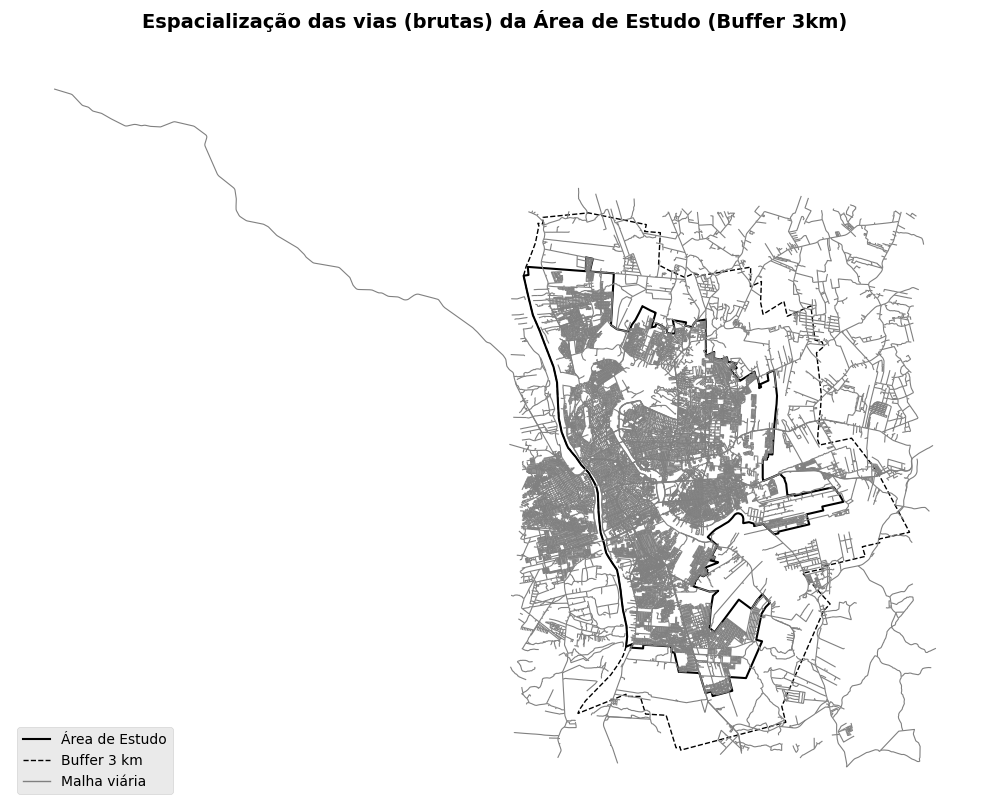

In [14]:
# --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 1️⃣ Malha viária — linhas cinza
gdf_segmentos_utm_processada.plot(ax=ax, color='gray', linewidth=0.8, label='Malha viária')

# 2️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
zu_buffer3km_utm.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 3️⃣ Área de Estudo — contorno preto contínuo
zu_utm.plot(ax=ax, facecolor='none', edgecolor='black', 
                 linewidth=1.5, label='Área de Estudo')

# --- Personalização do título e layout ---
ax.set_title("Espacialização das vias (brutas) da Área de Estudo (Buffer 3km)", 
             fontsize=14, fontweight='bold', pad=20)
ax.set_axis_off()

# --- Legenda personalizada ---
custom_legend = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='Área de Estudo'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='Buffer 3 km'),
    Line2D([0], [0], color='gray', linewidth=1, label='Malha viária'),
]

ax.legend(handles=custom_legend, loc='lower left', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

> Nessa representação todos os tipos de vias estão inclusas: ferrovias, serviços, trilhas, ciclovia, etc.

# 3. Filtrando por tipo de via

## Critério de Seleção (Contexto Brasileiro)

Vamos manter apenas as vias destinadas ao tráfego motorizado geral.

✅ Vias Selecionadas (Mantidas):

- trunk (Tronco): Rodovias importantes e vias expressas urbanas.
- primary (Primária): Vias arteriais principais da cidade.
- secondary (Secundária): Vias coletoras principais (ligam bairros).
- tertiary (Terciária): Vias coletoras locais.
- residential (Residencial): Ruas locais de acesso às casas (a maioria da malha).
- unclassified (Não classificada): Vias de ligação menores (comuns em periferias), acessíveis a carros.
- living_street (Via de pedestres compartilhada): Ruas onde o carro pode entrar, mas a prioridade é do pedestre (velocidade baixa).

❌ Vias Excluídas (Removidas):

- service (Serviço): Vias de acesso a estacionamentos, condomínios ou áreas industriais. Essencial para chegar exatamente ao ponto da UBS.
- Trilhos: standard_gauge (trem), light_rail (VLT/Metrô).
- Exclusivos Pedestres/Ciclistas: footway, pedestrian, steps, path (caminhos genéricos, geralmente não pavimentados e estreitos), cycleway.
- Rurais/Precárias: track (geralmente estradas de terra agrícola ou florestal. Na zona urbana, costumam ser caminhos informais que podem não suportar carros comuns. Por segurança metodológica, removemos).
- Desconhecido: unknown (melhor remover para evitar erros de topologia).

In [16]:
gdf_segmentos_utm_processada['class'].unique()

array(['standard_gauge', 'unclassified', 'path', 'tertiary',
       'residential', 'primary', 'track', 'service', 'trunk',
       'living_street', 'footway', 'unknown', 'secondary', 'pedestrian',
       'cycleway', 'steps', 'light_rail'], dtype=object)

In [17]:
# Definir a lista de classes de vias permitidas para automóveis
classes_automovel = [
    'trunk', 
    'primary', 
    'secondary', 
    'tertiary', 
    'residential', 
    'unclassified', 
    'living_street'
]

print(f"Filtrando grafo para manter apenas: {classes_automovel}")

# Aplicar o filtro no GeoDataFrame
# Mantemos apenas as linhas cujo valor da coluna 'class' está na nossa lista
gdf_vias_carro = gdf_segmentos_utm_processada[
    gdf_segmentos_utm_processada['class'].isin(classes_automovel)
].copy()

# Verificar o resultado
print(f"Total de segmentos antes: {len(gdf_segmentos_utm_processada)}")
print(f"Total de segmentos após filtro: {len(gdf_vias_carro)}")
print("Classes restantes:", gdf_vias_carro['class'].unique())

# Atualizar o nome da variável principal para continuar o processamento
# (Opcional, depende de como você usa no resto do código)
# arestas_gdf = gdf_vias_carro

Filtrando grafo para manter apenas: ['trunk', 'primary', 'secondary', 'tertiary', 'residential', 'unclassified', 'living_street']
Total de segmentos antes: 61012
Total de segmentos após filtro: 54872
Classes restantes: ['unclassified' 'tertiary' 'residential' 'primary' 'trunk' 'living_street'
 'secondary']


In [18]:
# Calcular a frequência de cada tipo de via
quantitativo_vias = gdf_vias_carro['class'].value_counts()

# Exibir o resultado em texto
print("--- Quantitativo de Vias por Classe ---")
print(quantitativo_vias)

# Dica: Calcular também a porcentagem para usar no texto da dissertação
porcentagem_vias = gdf_vias_carro['class'].value_counts(normalize=True) * 100
print("\n--- Porcentagem (%) ---")
print(porcentagem_vias.round(2)) # Arredondando para 2 casas decimais

--- Quantitativo de Vias por Classe ---
class
residential      40025
tertiary          5283
secondary         3347
primary           2623
unclassified      2077
living_street      854
trunk              663
Name: count, dtype: int64

--- Porcentagem (%) ---
class
residential      72.94
tertiary          9.63
secondary         6.10
primary           4.78
unclassified      3.79
living_street     1.56
trunk             1.21
Name: proportion, dtype: float64


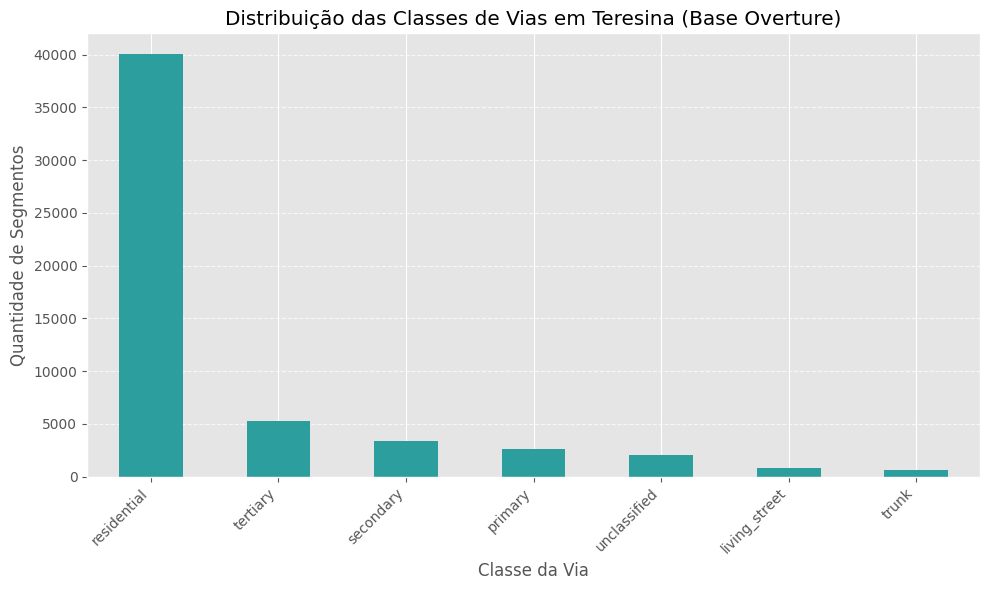

In [ ]:
# Criar gráfico de barras
plt.figure(figsize=(10, 6))
quantitativo_vias.plot(kind='bar', color='#2c9e9e') # Cor parecida com a do seu relatório

plt.title('Distribuição das Classes de Vias em Teresina (Base Overture)')
plt.xlabel('Classe da Via')
plt.ylabel('Quantidade de Segmentos')
plt.xticks(rotation=45, ha='right') # Rotacionar labels para ler melhor
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# 4. Atribuindo valores de velocidades por tipo de via, com base no CTB

In [20]:
import numpy as np

# --- ETAPA 2: Tratamento de Velocidade (Híbrido CTB + Dados Reais) ---
print("Iniciando tratamento inteligente de velocidades...")

# 2.1 Dicionário de Defaults CTB (Caso o dado seja nulo)
defaults_ctb = {
    'trunk': 80, 'primary': 60, 'secondary': 60,
    'tertiary': 40, 'residential': 30, 'unclassified': 30,
    'living_street': 20, 'service': 20
}

# 2.2 Função para extrair ou estimar a velocidade MÁXIMA
def obter_velocidade_maxima(row):
    # 1. Tenta ler do JSON existente no Overture
    val_existente = None
    if isinstance(row['speed_limits'], str):
        try:
            dados = json.loads(row['speed_limits'])
            if isinstance(dados, list) and len(dados) > 0:
                # Tenta pegar 'max_speed' > 'value'
                val_existente = dados[0].get('max_speed', {}).get('value')
        except:
            pass # Se der erro no JSON, ignora e vai pro default

    # 2. Se achou valor no JSON, retorna ele
    if val_existente is not None:
        return float(val_existente)
    
    # 3. Se não achou, usa o default do CTB baseado na classe
    return float(defaults_ctb.get(row['class'], 20)) # 20 é fallback seguro

# Aplica a função para criar uma coluna base de referência
print("Extraindo/Imputando Velocidade Máxima Legal...")
gdf_vias_carro['max_speed_ref'] = gdf_vias_carro.apply(obter_velocidade_maxima, axis=1)


# --- O PULO DO GATO: Ajuste para Velocidade Operacional (Realidade) ---

def calcular_velocidade_operacional(row):
    v_max = row['max_speed_ref']
    road_class = row['class']
    surface = str(row.get('road_surface', '')).lower() # Pega pavimentação se existir
    
    # Fator de Redução de Tráfego Urbano (Traffic Friction)
    # Vias maiores têm fluxo melhor, vias locais têm mais pare/siga e pedestres
    if road_class in ['trunk', 'primary']:
        fator = 0.85  # Perda de 15% (semáforos sincronizados, preferenciais)
    elif road_class in ['secondary', 'tertiary']:
        fator = 0.70  # Perda de 30%
    else:
        fator = 0.60  # Perda de 40% (quebra-molas, cruzamentos não sinalizados)
    
    # Penalidade por Pavimentação (Crucial para periferias)
    # Se for terra, areia, ou paralelepípedo ruim (sett), reduz drasticamente
    if any(x in surface for x in ['unpaved', 'dirt', 'earth', 'ground', 'sand']):
        return min(v_max * fator, 15.0) # Teto de 15km/h na terra
    elif 'sett' in surface or 'cobblestone' in surface: # Paralelepípedo
        return v_max * fator * 0.8 # Reduz mais 20%
        
    return v_max * fator

print("Calculando Velocidade Operacional (Média)...")
gdf_vias_carro['velocidade_media_kmh'] = gdf_vias_carro.apply(calcular_velocidade_operacional, axis=1)

# Arredondar para ficar bonito
gdf_vias_carro['velocidade_media_kmh'] = gdf_vias_carro['velocidade_media_kmh'].round(1)

print("Cálculo concluído.")
print(gdf_vias_carro[['class', 'max_speed_ref', 'velocidade_media_kmh']].head(10))

Iniciando tratamento inteligente de velocidades...
Extraindo/Imputando Velocidade Máxima Legal...
Calculando Velocidade Operacional (Média)...
Cálculo concluído.
           class  max_speed_ref  velocidade_media_kmh
20  unclassified           30.0                  15.0
22  unclassified           30.0                  15.0
23  unclassified           30.0                  15.0
24      tertiary           40.0                  15.0
25  unclassified           30.0                  15.0
26   residential           30.0                  15.0
27      tertiary           40.0                  28.0
28      tertiary           40.0                  28.0
29  unclassified           30.0                  15.0
30       primary           60.0                  51.0


In [21]:
# --- ETAPA 3: Preparação para Análise de Rede (Comprimento e Tempo) ---
print("\nPreparando colunas para análise de rede...")

# 3.2. Calcular o Comprimento (Length) em metros
# Agora .length nos dará o comprimento em metros
gdf_vias_carro['length'] = gdf_vias_carro.geometry.length

# 3.3. Calcular a Coluna de Tempo de Viagem (em Minutos)
# Esta é a coluna que será usada como 'edge_attr' (peso da aresta)
print("Calculando 'travel_time_min'...")
gdf_vias_carro['travel_time_min'] = (
    (gdf_vias_carro['length'] / 1000) /  # Distância em KM
    gdf_vias_carro['velocidade_media_kmh'] # Velocidade em KM/H
) * 60 # Resultado em MINUTOS

print("GeoDataFrame pronto para a topologia.")


Preparando colunas para análise de rede...
Calculando 'travel_time_min'...
GeoDataFrame pronto para a topologia.


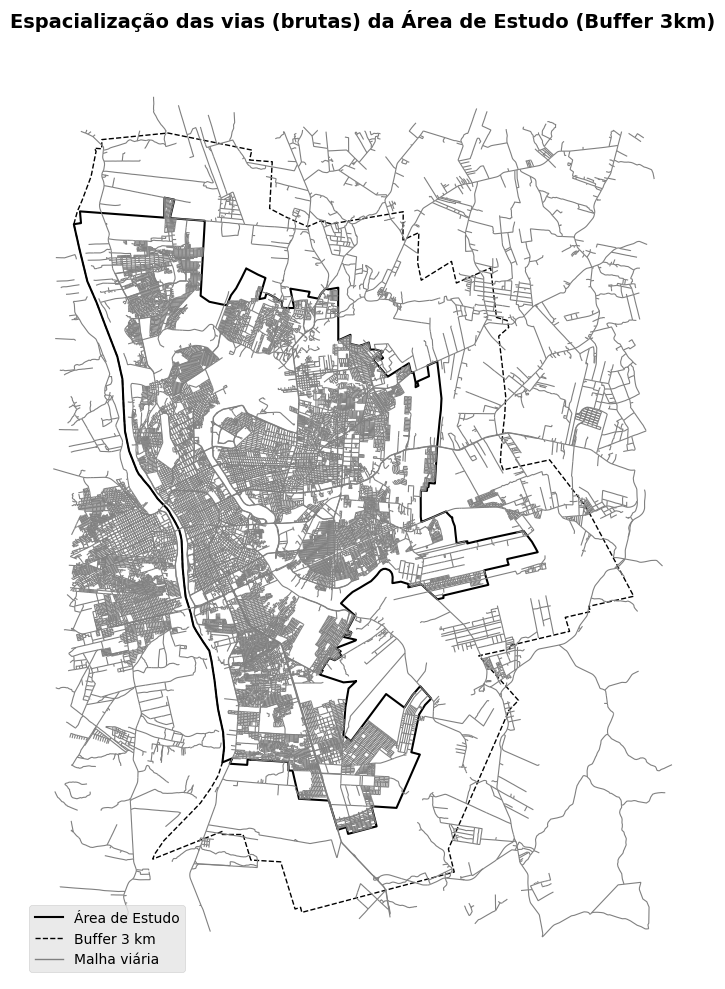

In [22]:
# --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 1️⃣ Malha viária — linhas cinza
gdf_vias_carro.plot(ax=ax, color='gray', linewidth=0.8, label='Malha viária')

# 2️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
zu_buffer3km_utm.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 3️⃣ Área de Estudo — contorno preto contínuo
zu_utm.plot(ax=ax, facecolor='none', edgecolor='black', 
                 linewidth=1.5, label='Área de Estudo')

# --- Personalização do título e layout ---
ax.set_title("Espacialização das vias (brutas) da Área de Estudo (Buffer 3km)", 
             fontsize=14, fontweight='bold', pad=20)
ax.set_axis_off()

# --- Legenda personalizada ---
custom_legend = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='Área de Estudo'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='Buffer 3 km'),
    Line2D([0], [0], color='gray', linewidth=1, label='Malha viária'),
]

ax.legend(handles=custom_legend, loc='lower left', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

In [23]:
# Seleciona os segmentos que INTERSECIONAM com a área de estudo 3km.
print(f"Total de segmentos antes da operação espacial: interseção: Segmentos = {len(gdf_vias_carro)}")

gdf_vias_carro_zu = gdf_vias_carro.sjoin(
    zu_buffer3km_utm, 
    how='inner', 
    predicate='intersects',
)

print(f"Total de segmentos antes da operação espacial: interseção: Segmentos = {len(gdf_vias_carro_zu)} ({len(gdf_vias_carro) - len(gdf_vias_carro_zu)})")

Total de segmentos antes da operação espacial: interseção: Segmentos = 54872
Total de segmentos antes da operação espacial: interseção: Segmentos = 44735 (10137)


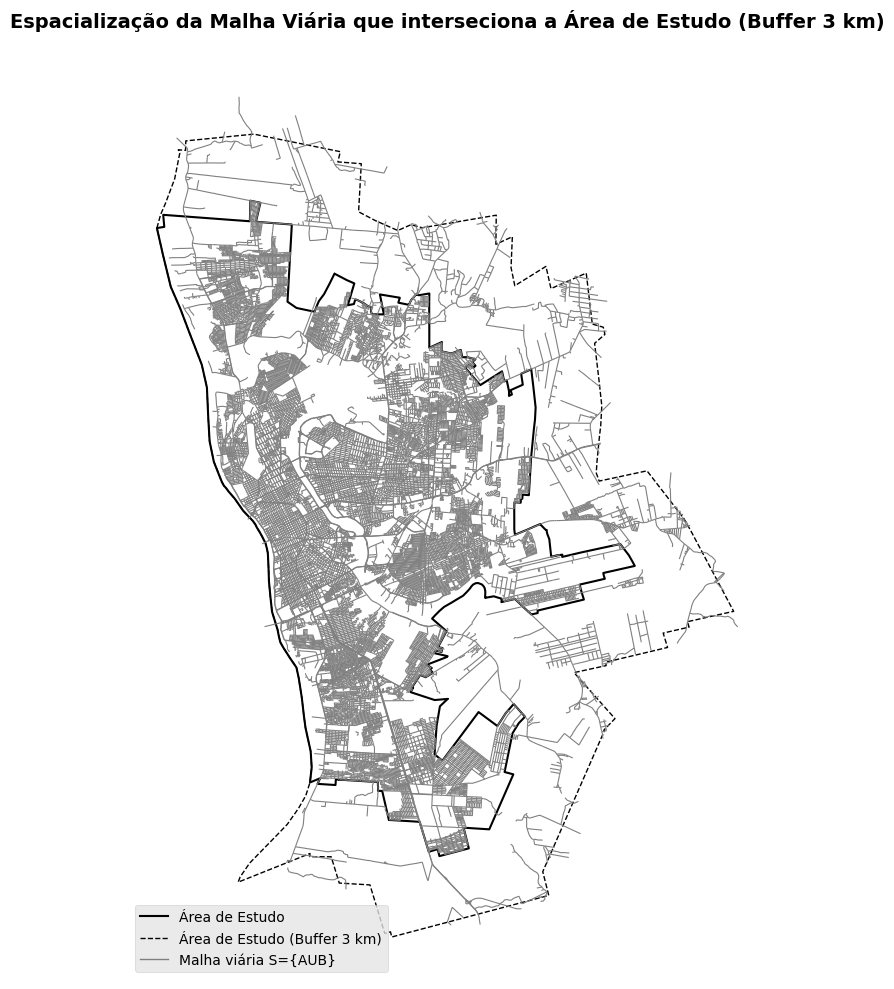

In [24]:
# --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 1️⃣ Malha viária — linhas cinza
gdf_vias_carro_zu.plot(ax=ax, color='gray', linewidth=0.8, label='Malha viária AUB')

# 2️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
zu_buffer3km_utm.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 3️⃣ Área de Estudo — contorno preto contínuo
zu_utm.plot(ax=ax, facecolor='none', edgecolor='black', 
                 linewidth=1.5, label='Área de Estudo')

# --- Personalização do título e layout ---
ax.set_title("Espacialização da Malha Viária que interseciona a Área de Estudo (Buffer 3 km)", 
             fontsize=14, fontweight='bold', pad=20)
ax.set_axis_off()

# --- Legenda personalizada ---
custom_legend = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='Área de Estudo'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='Área de Estudo (Buffer 3 km)'),
    Line2D([0], [0], color='gray', linewidth=1, label='Malha viária S={AUB}'),
]

ax.legend(handles=custom_legend, loc='lower left', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

Após a obtenção dos segmentos que intersecionam com a Área de Estudo, faz-se necessário a eliminação das vias pela quais não trafegam veículos motorizado (automóveis)

In [25]:
# Salvando em geoparquet
gdf_vias_carro_zu.to_parquet(
    "dados/overturemaps/intermediarios/finais/segmentos_automoveis.parquet"
)

In [26]:
# --- ETAPA 4: Converter Segmentos em Grafo Topológico (c2g.utils) ---
# Esta etapa é necessária. Ela transforma as linhas (ruas) em
# um grafo de nós (cruzamentos) e arestas (segmentos entre cruzamentos).
# Todos os atributos (incluindo 'travel_time_min') são preservados.
print("\nConvertendo segmentos de rua em estrutura de grafo topológico...")
nodes_gdf, edges_gdf = c2g_utils.segments_to_graph(gdf_vias_carro_zu)
print(f"Grafo criado com {len(nodes_gdf)} nós e {len(edges_gdf)} arestas.")

Removed 2 invalid geometries



Convertendo segmentos de rua em estrutura de grafo topológico...
Grafo criado com 29568 nós e 44733 arestas.


In [28]:
# --- 1. Salvar o GeoDataFrame de NÓS (Nodes) ---
# Nós são pontos (geralmente cruzamentos)
print("Salvando nodes_gdf...")
nodes_gdf.to_file(
    "./dados/overturemaps/intermediarios/finais/grafo_nos.geojson", 
    driver="GeoJSON"
)
print("Arquivo 'grafo_nos.gpkg' salvo com sucesso.")


# --- 2. Salvar o GeoDataFrame de ARESTAS (Edges) ---
# Arestas são linhas (os segmentos de rua com 'travel_time_min')
# Este é o arquivo mais importante para a função create_isochrone
print("\nSalvando edges_gdf...")
edges_gdf.to_parquet(
    "./dados/overturemaps/intermediarios/finais/grafo_arestas.parquet", 
)
print("Arquivo 'grafo_arestas.parquet' salvo com sucesso.")

Salvando nodes_gdf...
Arquivo 'grafo_nos.gpkg' salvo com sucesso.

Salvando edges_gdf...
Arquivo 'grafo_arestas.parquet' salvo com sucesso.
